In [2]:
 # import basic package
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style
import warnings
warnings.filterwarnings('ignore')
style.use('ggplot')
color_pal = [x['color'] for x in plt.rcParams['axes.prop_cycle']]


from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv1D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

# Pre-process

In [3]:
# From the previous ML part, we already split dataset into training and testing, hear we will call them.
train = pd.read_csv('FullData_nor_train.csv')
train.drop(columns='Unnamed: 0',inplace=True)
print(f'**** Successfully loading traing dataset ****')
test = pd.read_csv('FullData_nor_test.csv')
test.drop(columns='Unnamed: 0',inplace=True)
print(f'**** Successfully loading testing dataset ****')


**** Successfully loading traing dataset ****
**** Successfully loading testing dataset ****


# Modelling based on 80% of dataset

In [4]:
training, testing = train_test_split(train,test_size=0.2, random_state=42)

# Prepare for traning and validation dataset based on 80% of total dataset

In [7]:
# Setup X_,y_ from testing (20% of Full dataset) for future testing.
target_column = 'isFraud'
feature_columns = [c for c in training.columns if c!= 'isFraud']
y_ = testing[target_column].values
X_ = testing[feature_columns].values
print(f'X_.shape: {X_.shape}   y_.shape: {y_.shape}')

X_.shape: (118108, 570)   y_.shape: (118108,)


In [8]:
# Setup X,y from training (80% of Full dataset) for training.
y = training[target_column].values
X = training[feature_columns].values
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=42)
print(f'X_train.shape: {X_train.shape}   X_test.shape: {X_test.shape}')
print(f'y_train.shape: {y_train.shape}   y_test.shape: {y_test.shape}')

X_train.shape: (377945, 570)   X_test.shape: (94487, 570)
y_train.shape: (377945,)   y_test.shape: (94487,)


# Modelling (DL)

The model has been trained with the orginal dataset (96.5% normal v.s. 3.5% fraud)

In [11]:
model = Sequential()
model.add(Dense(units=128, input_dim = 570,activation='relu'))
model.add(Dense(units=256,activation='relu'))  
model.add(Dense(128,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(16,activation='relu'))
model.add(Dense(1,activation='sigmoid'))


In [12]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.fit(X_train,y_train,batch_size=150,epochs=15)

Epoch 1/15
377945/377945 [==============================] - 13s 35us/sample - loss: 0.1119 - acc: 0.9702
Epoch 2/15
377945/377945 [==============================] - 13s 33us/sample - loss: 0.1018 - acc: 0.9726
Epoch 3/15
377945/377945 [==============================] - 13s 34us/sample - loss: 0.0984 - acc: 0.9736
Epoch 4/15
377945/377945 [==============================] - 13s 35us/sample - loss: 0.0958 - acc: 0.9741
Epoch 5/15
377945/377945 [==============================] - 14s 37us/sample - loss: 0.0942 - acc: 0.9746
Epoch 6/15
377945/377945 [==============================] - 13s 34us/sample - loss: 0.0924 - acc: 0.9751
Epoch 7/15
377945/377945 [==============================] - 13s 34us/sample - loss: 0.0908 - acc: 0.9755
Epoch 8/15
377945/377945 [==============================] - 13s 34us/sample - loss: 0.0896 - acc: 0.9757
Epoch 9/15
377945/377945 [==============================] - 13s 34us/sample - loss: 0.0881 - acc: 0.9762
Epoch 10/15
377945/377945 [============================

In [13]:
score = model.evaluate(X_test, y_test)
print(score)

94487/94487 [==============================] - 3s 34us/sample - loss: 0.0923 - acc: 0.9752
[0.09228137764539475, 0.9752135]


Confusion matrix, without normalization
[[90956   138]
 [ 2204  1189]]


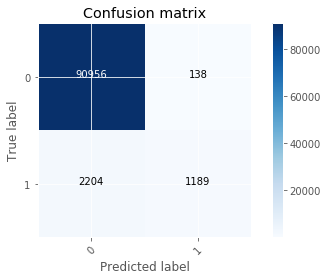

In [15]:
y_pred = model.predict(X_test)
y_test = pd.DataFrame(y_test)
cnf_matrix = confusion_matrix(y_test, y_pred.round())
plot_confusion_matrix(cnf_matrix, classes=[0,1])
plt.show()

Accuracy is 0.9751413960104311
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99    113866
         1.0       0.87      0.36      0.51      4242

    accuracy                           0.98    118108
   macro avg       0.92      0.68      0.75    118108
weighted avg       0.97      0.98      0.97    118108



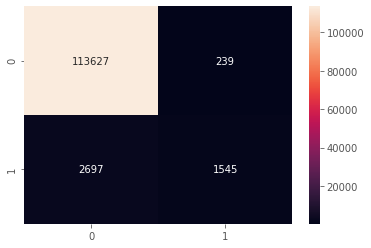

In [16]:
y_prob = model.predict_proba(X_)
for i in range(0,len(y_prob)):
#     print(i)
    if y_prob[i] >= 0.4:
        y_prob[i] = 1
    else:
        y_prob[i] = 0
        
# print(y_prob)
accuracy = accuracy_score(y_prob, y_)
print(f'Accuracy is {accuracy}')
print(classification_report(y_, y_prob))
cm = confusion_matrix(y_, y_prob)
sns.heatmap(cm,annot=True,fmt="d");

# Try Oversampling (RandomOverSampler)

In [17]:
os = RandomOverSampler(ratio=1, random_state=42)
X_res, y_res = os.fit_sample(X,y)

print('Original dataset shape {}'.format(Counter(y)))
print('Oversampling dataset shape {}'.format(Counter(y_res)))

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res,test_size=0.2, random_state=42)
print(f'X_train.shape: {X_train.shape}   X_test.shape: {X_test.shape}')
print(f'y_train.shape: {y_train.shape}   y_test.shape: {y_test.shape}')

Original dataset shape Counter({0.0: 456011, 1.0: 16421})
Oversampling dataset shape Counter({0.0: 456011, 1.0: 456011})
X_train.shape: (729617, 570)   X_test.shape: (182405, 570)
y_train.shape: (729617,)   y_test.shape: (182405,)


In [20]:
model = Sequential()
# model.add(Conv1D(filters = 256,input_shape = (None, 499),kernel_size =10, activation='relu'))
model.add(Dense(units=256, input_dim = 570,activation='relu'))
model.add(Dense(units=512,activation='relu'))  
model.add(Dense(256,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
# checkpoint
filepath="weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
# Fit the model
model.fit(X_res, y_res, validation_split=0.33, epochs=50, batch_size=100, callbacks=callbacks_list, verbose=0)


Epoch 00001: val_acc improved from -inf to 0.72778, saving model to weights-improvement-01-0.73.hdf5

Epoch 00002: val_acc improved from 0.72778 to 0.73228, saving model to weights-improvement-02-0.73.hdf5

Epoch 00003: val_acc did not improve from 0.73228

Epoch 00004: val_acc improved from 0.73228 to 0.82170, saving model to weights-improvement-04-0.82.hdf5

Epoch 00005: val_acc improved from 0.82170 to 0.86713, saving model to weights-improvement-05-0.87.hdf5

Epoch 00006: val_acc improved from 0.86713 to 0.88086, saving model to weights-improvement-06-0.88.hdf5

Epoch 00007: val_acc improved from 0.88086 to 0.90261, saving model to weights-improvement-07-0.90.hdf5

Epoch 00008: val_acc improved from 0.90261 to 0.95080, saving model to weights-improvement-08-0.95.hdf5

Epoch 00009: val_acc did not improve from 0.95080

Epoch 00010: val_acc did not improve from 0.95080

Epoch 00011: val_acc improved from 0.95080 to 0.96418, saving model to weights-improvement-11-0.96.hdf5

Epoch 000

In [21]:
model = load_model('weights-improvement-35-1.00.hdf5')

W0901 09:38:41.655994 4508431808 deprecation.py:506] From /anaconda3/envs/python/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0901 09:38:41.658146 4508431808 deprecation.py:506] From /anaconda3/envs/python/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Accuracy is 0.975149862837403
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99    113866
         1.0       0.65      0.67      0.66      4242

    accuracy                           0.98    118108
   macro avg       0.82      0.83      0.82    118108
weighted avg       0.98      0.98      0.98    118108



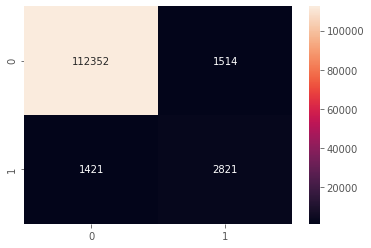

In [22]:
y_prob = model.predict_proba(X_)
for i in range(0,len(y_prob)):
#     print(i)
    if y_prob[i] >= 0.4:
        y_prob[i] = 1
    else:
        y_prob[i] = 0
        
# print(y_prob)
accuracy = accuracy_score(y_prob, y_)
print(f'Accuracy is {accuracy}')
print(classification_report(y_, y_prob))
cm = confusion_matrix(y_, y_prob)
sns.heatmap(cm,annot=True,fmt="d");

# Functions

In [14]:
import matplotlib.pyplot as plt
import itertools

from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()